# Characterization of RFE

In [1]:
import selector
from selector import energy_point_selector

from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
energy_point_selector = reload(selector.energy_point_selector)

In [7]:
Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

energy = np.linspace(7090, 7196, 54)

ref_energy, Refs_dict_tmp, _ = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')

data_columns = ['StainlessSteelNP', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'FeIII_sulfate', 'Fe(III)PO4', 'Hematite_NP',
                'Maghemite', 'Goethite', 'HFO']

Refs_dict = {key: Refs_dict_tmp[key] for key in data_columns}
Refs_raw = np.array(list(Refs_dict.values()))

data_columns = ['Stainless Steel', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'Fe(III)SO4', 'Fe(III)PO4', 'Hematite',
                'Maghemite', 'Goethite', 'HFO']
energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

data = Fe_xanes_tmp
fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict,
                                                                whiteline_range=-1,
                                                                pre_edge_offset=10,
                                                                post_edge_offset=18)

Refs, Refs_dict = normalize_spectra(energy, Refs, Refs_dict, pre_edge_offset=10,
                                    post_edge_offset=25, whiteline_range=-1)
Refs = np.array(Refs)

(12, 196)


In [5]:
x = np.linspace(30, 50, 300)
Mus = np.array([[34, 40, 46], [33, 38, 47], [34, 36, 46]])
Sigmas = np.array([[mu / 50 for mu in mus] for mus in Mus])

def normal(x, mu, sig):
    return ( 1 / sig * np.sqrt(2 * np.pi) ) * np.exp( -0.5 * ((x - mu) / sig)**2 )

Basis = np.array([[normal(x, Mus[j, i], Sigmas[j, i]) for i in range(len(Mus))] for j in range(len(Mus))])
print(Basis.shape)

(3, 3, 300)


In [8]:
RFEs = []
Xs = []
reps = 10
kwargs = {'N': 200, 'scale': 0.0, 'dropout': 0.5}

for basis in Basis:
    print('Basis')
    rfes, X = [], []
    for i in range(reps):
        print(i, end='\r')
        data, coeffs = generate_linear_combos(basis, **kwargs)

        select = energy_point_selector.Selector(data, coeffs)
        rfe, score = select.select_energy_points(estimator='Linear Regression', n_points=1,
                                                 verbose=True, scoring='r2')
        rfes.append(rfe)
        energy_measurements = x[rfe.support_]
        indices = [i for i, e in enumerate(x) if e in energy_measurements]
        X.append(data)
    RFEs.append(rfes)
    Xs.append(X)

Basis
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Basis
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Basis
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)


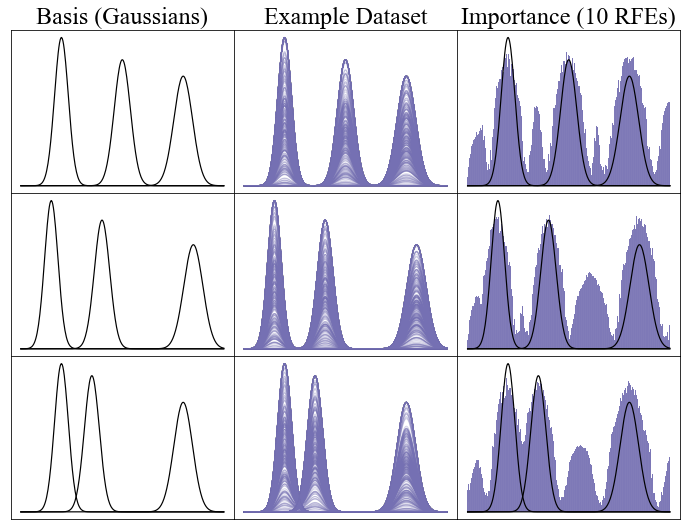

In [102]:
res = x[1] - x[0]
titles= ['Basis (Gaussians)', 'Example Dataset', f'Importance ({reps} RFEs)']
    
ncols = 3
nrows = len(Mus)
fig, axes = plt.subplots(figsize=(4 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, basis in enumerate(Basis):
    ranks = len(x) * reps - np.sum(np.array([rfe.ranking_ for rfe in RFEs[i]], dtype=float), axis=0)
    for b in basis:
        for ax in axes[i]:
            ax.plot(x, b, linewidth=1.2, color='k')
    for d in Xs[i][0]:
        axes[i, 1].plot(x, d, linewidth=1, color=plt.cm.Dark2(2), alpha=0.3)
    axes[i, 2].bar(x, ranks / np.max(ranks) * np.max(basis) * 0.9 , 
                   width=res, ec='w', linewidth=0.05, color=plt.cm.Dark2(2))

for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylim(axes[i, 0].get_ylim())
        if i == 0:
            ax.set_title(titles[j], fontsize=24)

In [6]:
N = len(normalized_spectra)
basis_sizes = [10, 20, 50]
indices = np.array([np.random.randint(N, size=s) for s in basis_sizes])
Basis = [np.array([normalized_spectra[i] for i in idxs], dtype=float) for idxs in indices]

C:\Users\saman\AppData\Local\Temp\ipykernel_12912\2349870348.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  indices = np.array([np.random.randint(N, size=s) for s in basis_sizes])


In [11]:
RFEs = []
Xs = []
Ps = []
T_basis = []
reps = 10
x = energy
pca = PCA(n_components=6)
kwargs = {'N': 1000, 'scale': 0.0, 'dropout': 0.85}

for basis in Basis:
    print('Basis')
    pca.fit(basis)
    transformed_basis = pca.fit_transform(basis) @ pca.components_
    T_basis.append(transformed_basis)
    rfes, X, P = [], [], []
    for i in range(reps):
        print(i, end='\r')
        data, coeffs = generate_linear_combos(basis, **kwargs)
        transformed_data = pca.transform(data)
        projections = transformed_data @ pca.components_
        rfe_double = []
        for linearize in [False, True]:
            if linearize:
                select = energy_point_selector.Selector(projections, transformed_data)
            else:
                select = energy_point_selector.Selector(data, coeffs)
            
            rfe, score = select.select_energy_points(estimator='Linear Regression', n_points=1,
                                                     verbose=True, scoring='r2')
            rfe_double.append(rfe)
        rfes.append(rfe_double)
            
        X.append(data)
        P.append(projections)

    RFEs.append(rfes)
    Xs.append(X)
    Ps.append(P)
RFEs = np.array(RFEs)

Basis
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Basis
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Basis
Score: 0.797 (0.029)
Score: 1.000 (0.000)
Score: 0.805 (0.035)
Score: 1.000 (0.000)
Score: 0.761 (0.086)
Score: 1.000 (0.000)
Score: 0.789 (0.

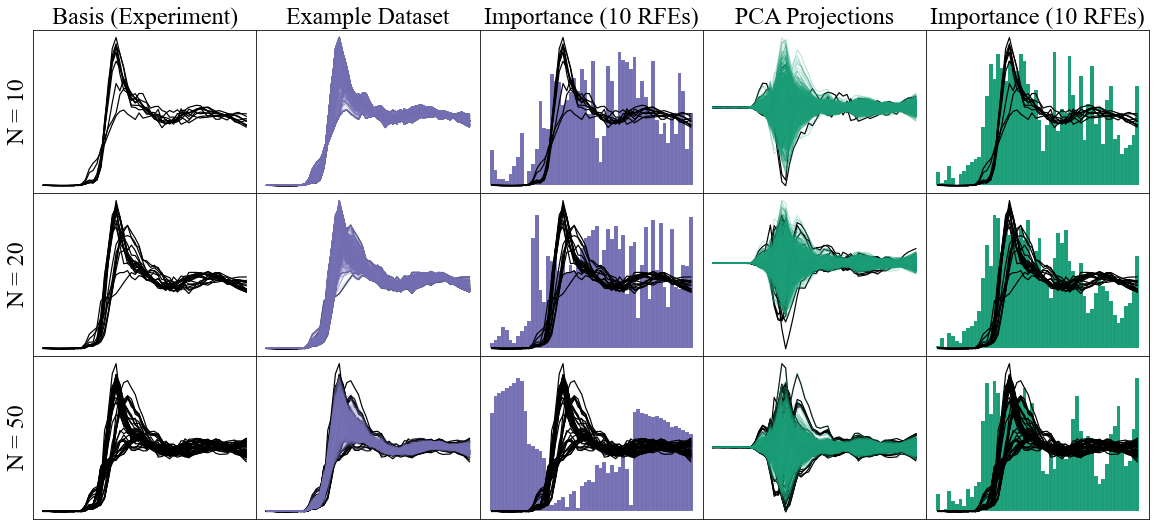

In [170]:
res = x[1] - x[0]
titles= ['Basis (Experiment)', 'Example Dataset', f'Importance ({reps} RFEs)', 
         'PCA Projections', f'Importance ({reps} RFEs)']
    
ncols = 5
nrows = len(basis_sizes)
fig, axes = plt.subplots(figsize=(4 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0., hspace=0.)

for i, basis in enumerate(Basis):
    Ranks = np.array([len(x) * reps 
                       - np.sum(np.array([rfe.ranking_ for rfe in RFEs[i, :, j]], 
                                        dtype=float), axis=0)
                       for j in range(2)])
    colors = [plt.cm.Dark2(2), plt.cm.Dark2(0)]
    for b in basis:
        for ax in axes[i, [0, 1, 2, 4]]:
            ax.plot(x, b, linewidth=1.2, color='k')
    for tb in T_basis[i]:
        axes[i, 3].plot(x, tb, linewidth=1.2, color='k')
    for d in Xs[i][0]:
        axes[i, 1].plot(x, d, linewidth=1, color=colors[0], alpha=0.3)
    for p in P[i]:
        axes[i, 3].plot(x, p, linewidth=1, color=colors[1], alpha=0.3)
    
    for j, ranks in enumerate(Ranks):
        axes[i, 2 + j * 2].bar(x, ranks / np.max(ranks) * np.max(basis) * 0.9 , 
                               width=res, ec='w', linewidth=0.05, color=colors[j])

for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        ax.set_yticks([])
        ax.set_xticks([])
        if j != 3:
            ax.set_ylim(axes[i, 0].get_ylim())
        if i == 0:
            ax.set_title(titles[j], fontsize=24)
        if j == 0:
            ax.set_ylabel(f'N = {basis_sizes[i]}', fontsize=24)

In [6]:
basis = Refs.copy()

RFEs = []
Xs = []
Ps = []

reps = 10
x = energy
pca = PCA(n_components=6)
kwargs = {'N': 1000, 'scale': 0.0, 'dropout': 0.8}

pca = pca.fit(basis)
projected_basis = pca.transform(basis) @ pca.components_

rfes, X, P = [], [], []
for i in range(reps):
    print(i, end='\r')
    data, coeffs = generate_linear_combos(basis, **kwargs)
    transformed_data = pca.transform(data)
    projections = transformed_data @ pca.components_
    rfe_double = []
    for linearize in [False, True]:
        if linearize:
            select = energy_point_selector.Selector(projections, transformed_data)
        else:
            select = energy_point_selector.Selector(data, coeffs)
            
        rfe, score = select.select_energy_points(estimator='Linear Regression', n_points=1,
                                                 verbose=True, scoring='r2')
        rfe_double.append(rfe)
    rfes.append(rfe_double)
            
    X.append(data)
    P.append(projections)

RFEs.append(rfes)
Xs.append(X)
Ps.append(P)

RFEs = np.array(RFEs)

Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)
Score: 1.000 (0.000)


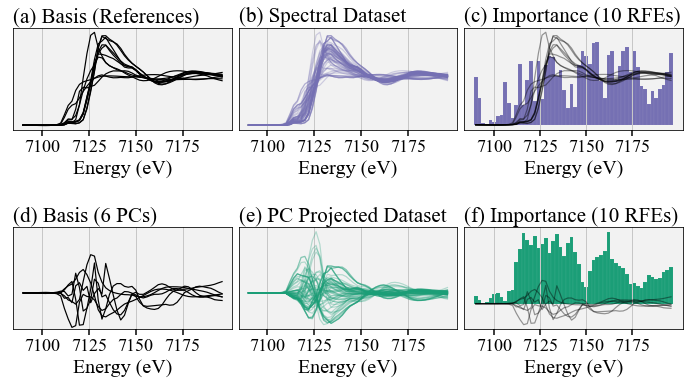

In [18]:
res = x[1] - x[0]
titles= [['(a) Basis (References)', '(b) Spectral Dataset', f'(c) Importance ({reps} RFEs)'], 
         ['(d) Basis (6 PCs)', '(e) PC Projected Dataset', f'(f) Importance ({reps} RFEs)']]
indices = [13, 15, 16, 18, 19, 22, 25, 26, 33, 37, 47, 53]
    
ncols = 3
nrows = 2
space = 0.95
fig, axes = plt.subplots(figsize=(4. * ncols, 2.3 * nrows + space), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0.03, hspace=space)

Ranks = np.array([len(x) * reps 
                  - np.sum(np.array([rfe.ranking_ for rfe in RFEs[0, :, j]], 
                                        dtype=float), axis=0)
                  for j in range(2)])

colors = [plt.cm.Dark2(2), plt.cm.Dark2(0)]

for b in basis:
    for i in [0, 2]:
        ax = axes[0, i]
        if i == 0:
            alpha = 1
        else:
            alpha = 0.4
        ax.plot(x, b, linewidth=1.2, color='k', alpha=alpha)

for tb in pca.components_: #projected_basis:
    for i in [0, 2]:
        ax = axes[1, i]
        if i == 0:
            alpha = 1
        else:
            alpha = 0.4
        ax.plot(x, tb, linewidth=1.2, color='k', alpha=alpha)

for d in Xs[0][0][:70]:
    axes[0, 1].plot(x, d, linewidth=1.2, color=colors[0], alpha=0.3)

for p in P[0][:70]:
    axes[1, 1].plot(x, p, linewidth=1.2, color=colors[1], alpha=0.3)
    
for j, ranks in enumerate(Ranks):
    normalized_ranks = ranks / np.max(ranks) * np.max(basis) * 0.9 
    axes[j, 2].bar(x, normalized_ranks, 
                   width=res, ec='w', linewidth=0.05, color=colors[j])

xticks = [7100, 7125, 7150, 7175]
for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        ax.set_yticks([])
        ax.set_xticks(xticks)
        ax.set_xlabel('Energy (eV)', fontsize=20)
        for xv in xticks:
            ax.axvline(xv, linewidth=1, color=plt.cm.tab20(15), zorder=1)
        ax.tick_params(length=6, width=1.5, labelsize=18)
        ax.set_facecolor(plt.cm.Pastel1(9))
        if j != 2:
            ax.set_ylim(axes[i, 1].get_ylim())
        ax.set_title(titles[i][j], fontsize=21, loc='left')
plt.savefig('Figures/RFE_trained_on_PCA_vs_spectra.png', dpi=600, bbox_inches='tight')

In [7]:
true_contrib_indices = [0, 2, 3, 7]
true_basis = Refs[true_contrib_indices]
short_coeffs = np.array([list(nnls(true_basis.T, target)[0]) for target in normalized_spectra])

true_coeffs = np.zeros((len(normalized_spectra), len(Refs)))
for j, idx in enumerate(true_contrib_indices):
    true_coeffs[:, idx] = short_coeffs[:, j]

In [35]:
basis = Refs.copy()
N = 5000
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.8}
pca = PCA(n_components=6)
pca = pca.fit(basis)

data, coeffs = generate_linear_combos(basis, **kwargs)
transformed_data = pca.transform(data)
projections = transformed_data @ pca.components_

# test different number of points to keep
n_points_to_keep = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

whiteline_modes = ['max', 'gradient']
Norm_errors = [[], []]
Pre_Norm = [[], []]
Post_Norm = [[], []]
LCF_scores = []
Exp_LCF_scores = []

select = energy_point_selector.Selector(projections, transformed_data)
rfe, _ = select.select_energy_points(estimator='Linear Regression', n_points=4,
                                     verbose=True, scoring='r2')

post_edge_energy_threshold = 7150
whiteline_threshold = 7138

for j, n_pts in enumerate(n_points_to_keep):
    print(f'\nChoosing {n_pts} points.')
    indices = [i for i, rank in enumerate(rfe.ranking_) if rank <= 1 + j]
    
    sliced_data = np.array([data[:, idx] for idx in indices])
    sliced_basis = np.array([Refs[:, idx] for idx in indices])
    pred_coeffs = get_coeffs_from_spectra(sliced_data.T, sliced_basis.T)
    score = np.sqrt(mean_squared_error(coeffs, pred_coeffs))
    LCF_scores.append(score)
    print(f'Sim LCF score: {score}')
    
    indices.insert(0, 0)
    indices.insert(1, 10)
    indices.append(53)
    print(indices)
    
    prenormalized_subset = np.array(normalized_spectra)[:, indices]
    ref_subset = Refs[:, indices]

    data_subset = np.array(filtered_spectra)[:, indices]
    energy_subset = np.array(energy[indices])
    prenormalized_subset = np.array(normalized_spectra)[:, indices]
    post = np.sum(energy[indices] > post_edge_energy_threshold)
    print(f'Post pts = {post}')
    
    whiteline_range = np.sum(energy[indices] < whiteline_threshold)
    print(f'Whiteline range = {whiteline_range}')
    
    for m, mode in enumerate(whiteline_modes):
        postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                              data_subset,
                                                                              filtered_spectra_dict,
                                                                              pre_edge_offset=2,
                                                                              post_edge_offset=-post,
                                                                              whiteline_range=whiteline_range,
                                                                              whiteline_mode=mode)

        norm_error = np.sqrt(mean_squared_error(prenormalized_subset, postnormalized_subset))
        Norm_errors[m].append(norm_error)
        print(f'Norm Error: {norm_error}')
    
        Pre_Norm[m].append(prenormalized_subset)
        Post_Norm[m].append(postnormalized_subset)
        
        if m == 0:
            pred_coeffs = get_coeffs_from_spectra(postnormalized_subset, ref_subset)
            score = np.sqrt(mean_squared_error(true_coeffs, pred_coeffs))
            Exp_LCF_scores.append(score)
            print(f'Exp LCF score: {score}')

Score: 1.000 (0.000)

Choosing 4 points.
Sim LCF score: 0.1376311586904013
[0, 10, 13, 16, 22, 36, 53]
Post pts = 2
Whiteline range = 5
Norm Error: 0.09020344154564097
Exp LCF score: 0.23466810085353193
Norm Error: 0.11919990139374563

Choosing 5 points.
Sim LCF score: 0.11782027480306749
[0, 10, 13, 16, 22, 26, 36, 53]
Post pts = 2
Whiteline range = 5
Norm Error: 0.13267533426127118
Exp LCF score: 0.24297619809380067
Norm Error: 0.10555100548924018

Choosing 6 points.
Sim LCF score: 0.09480349492406691
[0, 10, 13, 16, 19, 22, 26, 36, 53]
Post pts = 2
Whiteline range = 6
Norm Error: 0.15451745180977386
Exp LCF score: 0.13266862158630166
Norm Error: 0.15873360683457977

Choosing 7 points.
Sim LCF score: 0.08918200939892228
[0, 10, 13, 14, 16, 19, 22, 26, 36, 53]
Post pts = 2
Whiteline range = 7
Norm Error: 0.14731778909516843
Exp LCF score: 0.14227402085921065
Norm Error: 0.15067324496307577

Choosing 8 points.
Sim LCF score: 0.073531723402256
[0, 10, 13, 14, 16, 19, 21, 22, 26, 36, 53]

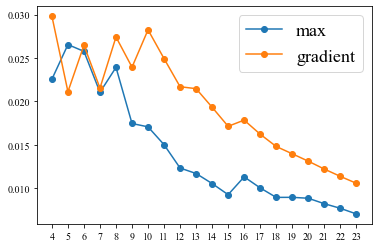

In [40]:
plt.plot(n_points_to_keep, np.array(Norm_errors[0]) / n_points_to_keep, 'o-', label=whiteline_modes[0])
plt.plot(n_points_to_keep, np.array(Norm_errors[1]) / n_points_to_keep, 'o-', label=whiteline_modes[1])
plt.legend(fontsize=18)
plt.xticks(n_points_to_keep)
plt.show()

In [42]:
df1 = pd.DataFrame(data=np.array(LCF_scores))
df2 = pd.DataFrame(data=np.array(Exp_LCF_scores))
df3 = pd.DataFrame(data=np.array(Norm_errors))

df1.to_csv(f'RFE Characterization/LCF_scores.csv')
df2.to_csv(f'RFE Characterization/Exp_LCF_scores.csv')
df3.to_csv(f'RFE Characterization/Norm_errors.csv')

In [84]:
ensemble_size = 10
n_energies = 6
models = ['Rand', 'RFE', 'RF', 'DT', 'LR']
Sim_LCF_by_model = [[] for m in models]
Exp_LCF_by_model = [[] for m in models]
Indices = [[] for m in models]
N = 1000
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.8}
pca = PCA(n_components=6)
basis = Refs.copy()
pca = pca.fit(basis)

post_edge_energy_threshold = 7150
whiteline_threshold = 7138

for m, model in enumerate(models):
    print(f'\n{model}')
    for rep in range(ensemble_size):
        data, coeffs = generate_linear_combos(basis, **kwargs)
        transformed_data = pca.transform(data)
        projections = transformed_data @ pca.components_
        if model == 'Rand':
            indices = np.random.choice(np.arange(len(energy)), size=n_energies, replace=False)
            while (1 in indices) or (10 in indices) or (53 in indices):
                indices = np.random.choice(np.arange(len(energy)), size=n_energies, replace=False)
            indices = list(np.sort(indices))
        elif model == 'RFE':
            select = energy_point_selector.Selector(projections, transformed_data)
            rfe_, _ = select.select_energy_points(estimator='Linear Regression', n_points=n_energies,
                                                 verbose=True, scoring='r2')
            indices = [i for i, boolean in enumerate(rfe_.support_) if boolean == True]
        elif model == 'RF':
            predictor = RandomForestRegressor()
            predictor.fit(projections, transformed_data)
            importance = np.argsort(predictor.feature_importances_)[::-1]
            indices= list(np.sort(importance[:n_energies]))
        elif model == 'DT':
            predictor = DecisionTreeRegressor()
            predictor.fit(projections, transformed_data)
            importance = np.argsort(predictor.feature_importances_)[::-1]
            indices= list(np.sort(importance[:n_energies]))
        elif model == 'LR':
            predictor = LinearRegression()
            predictor.fit(projections, transformed_data)
            importance = np.argsort(np.abs(np.average(predictor.coef_, axis=0)))[::-1]
            indices= list(np.sort(importance[:n_energies]))
        if (1 in indices) or (10 in indices) or (53 in indices):
            print(f'Model: {model}, Rep: {rep} has indices {indices}')
    
        sliced_data = np.array([data[:, idx] for idx in indices])
        sliced_basis = np.array([Refs[:, idx] for idx in indices])
        pred_coeffs = get_coeffs_from_spectra(sliced_data.T, sliced_basis.T)
        score = np.sqrt(mean_squared_error(coeffs, pred_coeffs))
        
        Sim_LCF_by_model[m].append(score)
        
        indices.insert(0, 0)
        indices.insert(1, 10)
        indices.append(53)
        indices = list(np.sort(indices))
        print(indices)

        prenormalized_subset = np.array(normalized_spectra)[:, indices]
        ref_subset = Refs[:, indices]

        data_subset = np.array(filtered_spectra)[:, indices]
        energy_subset = np.array(energy[indices])
        
        post = np.sum(energy[indices] > post_edge_energy_threshold)
        whiteline_range = np.sum(energy[indices] < whiteline_threshold)

        postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                              data_subset,
                                                                              filtered_spectra_dict,
                                                                              pre_edge_offset=2,
                                                                              post_edge_offset=-post,
                                                                              whiteline_range=whiteline_range,
                                                                              whiteline_mode='max')
        pred_coeffs = get_coeffs_from_spectra(postnormalized_subset, ref_subset)
        score = np.sqrt(mean_squared_error(true_coeffs, pred_coeffs))
        
        Exp_LCF_by_model[m].append(score)
        Indices[m].append(indices)
    
    print(f'Sim LCF score: {np.average(Sim_LCF_by_model[m])}')
    print(f'Exp LCF score: {np.average(Exp_LCF_by_model[m])}')


Rand
[0, 10, 16, 27, 29, 41, 43, 45, 50, 53]


NameError: name 'true_coeffs' is not defined

In [ ]:
for i, model in enumerate(models):
    df = pd.DataFrame(data=np.array(Indices[i]))
    df.to_csv(f'RFE Characterization/Indices_{model}.csv')
    
df = pd.DataFrame(data=np.array(Sim_LCF_by_model))
df.to_csv(f'RFE Characterization/Sim_LCF_by_model.csv')

df = pd.DataFrame(data=np.array(Exp_LCF_by_model))
df.to_csv(f'RFE Characterization/Exp_LCF_by_model.csv')

# Reading in Saved Characterization Data

In [8]:
basis = Refs.copy()
N = 5000
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.8}
pca = PCA(n_components=6)
pca = pca.fit(basis)

data, coeffs = generate_linear_combos(basis, **kwargs)
transformed_data = pca.transform(data)
projections = transformed_data @ pca.components_

n_points_to_keep = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

select = energy_point_selector.Selector(projections, transformed_data)
RFE, _ = select.select_energy_points(estimator='Linear Regression', n_points=4,
                                     verbose=True, scoring='r2')

select = energy_point_selector.Selector(projections, transformed_data)
rfe, _ = select.select_energy_points(estimator='Linear Regression', n_points=1,
                                     verbose=True, scoring='r2')

Score: 1.000 (0.000)
Score: 1.000 (0.000)


In [9]:
ensemble_size = 10
n_energies = 7
models = ['Rand', 'RFE', 'RF', 'DT', 'LR']
Indices = [[] for m in models]

In [10]:
LCF_scores = np.array(pd.read_csv(f'RFE Characterization/LCF_scores.csv'))[:, 1:]
Exp_LCF_scores = np.array(pd.read_csv(f'RFE Characterization/Exp_LCF_scores.csv'))[:, 1:]
Norm_errors = np.array(pd.read_csv(f'RFE Characterization/Norm_errors.csv'))[:, 1:]

for i, model in enumerate(models):
    Indices[i] = np.array(pd.read_csv(f'RFE Characterization/Indices_{model}.csv'))[:, 1:]
Indices = np.array(Indices)
print(Indices.shape)

Sim_LCF_by_model = np.array(pd.read_csv(f'RFE Characterization/Sim_LCF_by_model.csv'))[:, 1:]
Exp_LCF_by_model = np.array(pd.read_csv(f'RFE Characterization/Exp_LCF_by_model.csv'))[:, 1:]
print(Sim_LCF_by_model.shape, Exp_LCF_by_model.shape)

(5, 10, 10)
(5, 10) (5, 10)


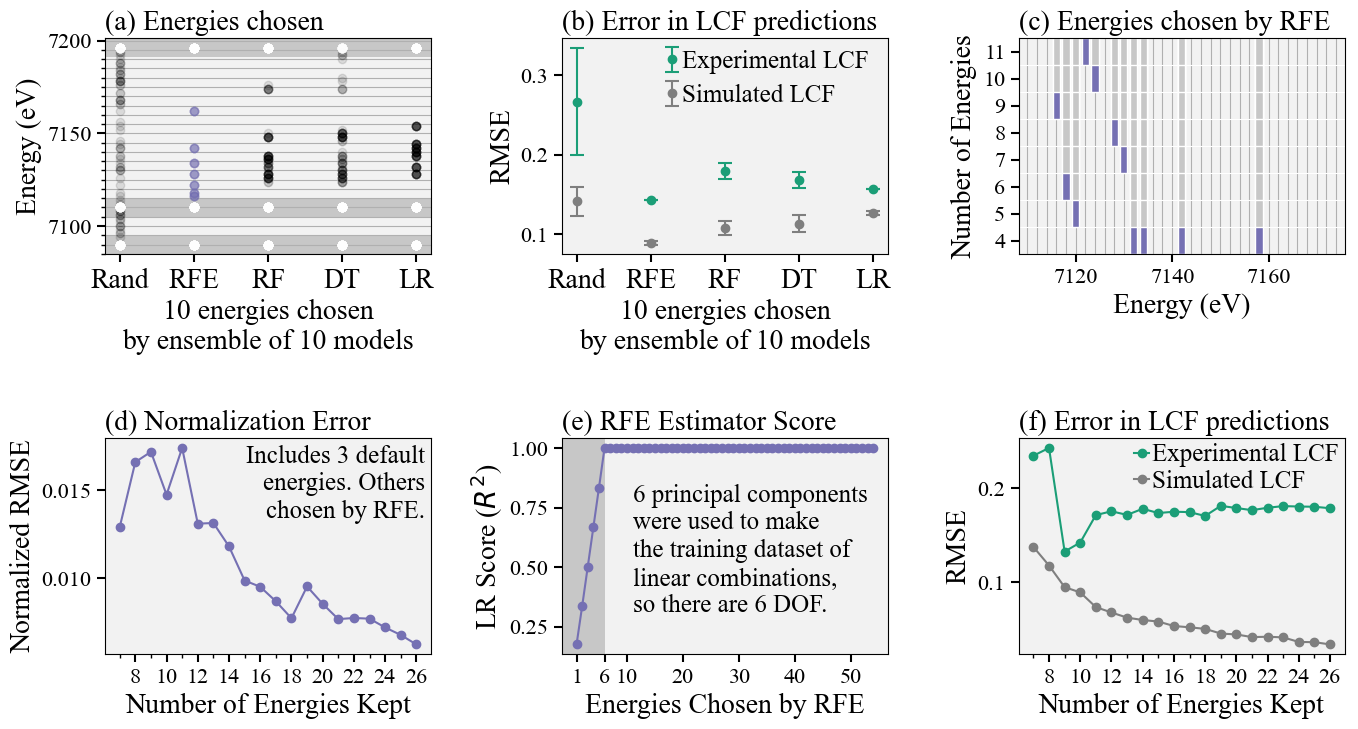

In [12]:
fig, axes = plt.subplots(figsize=(16, 8), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.4, hspace=0.85)

total_energies = len(energy)

ax = axes[0, 0]
Indices= np.array(Indices)
colors = ['k' for i in range(len(models))]
colors[1] = plt.cm.Dark2(2)
for r in range(ensemble_size):
    for m in range(len(models)):
        ax.plot([m for i in range(3, n_energies + 3)], energy[Indices[m, r]][2:-1], 
                marker='o',  color=colors[m], alpha=0.1, linestyle='none')
        ax.plot([m for i in range(2)], energy[Indices[m, r]][:2], 
                marker='o',  color='w', alpha=0.9, linestyle='none')
        ax.plot([m], energy[Indices[m, r]][-1:], marker='o',  color='w', alpha=0.9, linestyle='none')
ax.set_title('(a) Energies chosen', fontsize=20, loc='left')
ax.set_ylabel('Energy (eV)', fontsize=20)
ax.tick_params(width=1.5, length=6, axis='x', labelsize=20)
ax.tick_params(width=1.5, length=6, axis='y', labelsize=16)
ax.set_xlabel(f'{n_energies + 3} energies chosen\nby ensemble of {ensemble_size} models', fontsize=20)
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)
rect = patches.Rectangle((ax.get_xlim()[0], energy[0] + 5), 
                          ax.get_xlim()[1] - ax.get_xlim()[0], 
                         -(energy[0] + 10 - ax.get_ylim()[0]), linewidth=1, 
                          facecolor=plt.cm.tab20(15), zorder=1)
rect2 = patches.Rectangle((ax.get_xlim()[0], energy[10] + 5), 
                          ax.get_xlim()[1] - ax.get_xlim()[0], 
                         -10, linewidth=1, 
                          facecolor=plt.cm.tab20(15), zorder=1)
rect3 = patches.Rectangle((ax.get_xlim()[0], energy[53] + 5), 
                          ax.get_xlim()[1] - ax.get_xlim()[0], 
                         -10, linewidth=1, 
                          facecolor=plt.cm.tab20(15), zorder=1)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.grid(axis='y', which='both', zorder=1)
ax.tick_params(length=3, width=1., which='minor')
ax.add_patch(rect)
ax.add_patch(rect2)
ax.add_patch(rect3)


ax = axes[0, 1]
ax.errorbar(np.arange(len(models)), np.average(Exp_LCF_by_model, axis=1), capsize=5,
            yerr=np.std(Exp_LCF_by_model, axis=1), c=plt.cm.Dark2(0), linewidth=1.5,
            capthick=1.5, marker='o', linestyle='none', label='Experimental LCF')
ax.errorbar(np.arange(len(models)), np.average(Sim_LCF_by_model, axis=1), capsize=5,
            yerr=np.std(Sim_LCF_by_model, axis=1), c=plt.cm.tab20(14), linewidth=1.5,
            capthick=1.5, marker='o', linestyle='none', label='Simulated LCF')
leg = ax.legend(fontsize=18, framealpha=0., handlelength=.6, loc=1, facecolor=plt.cm.tab20(15),
                labelspacing=.4, handletextpad=0.12, bbox_to_anchor=(1.01, 1.05))
ax.set_title('(b) Error in LCF predictions', fontsize=20, loc='left')
ax.set_ylabel('RMSE', fontsize=20)
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)
ax.set_xlabel(f'{n_energies + 3} energies chosen\nby ensemble of {ensemble_size} models', fontsize=20)
ax.tick_params(width=1.5, length=6, axis='x', labelsize=20)
ax.tick_params(width=1.5, length=6, axis='y', labelsize=16)
ax.set_ylim(ax.get_ylim()[0], (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1. + ax.get_ylim()[0])


ax = axes[0, 2]
for j, n_pts in enumerate(n_points_to_keep):
    indices = [i for i, rank in enumerate(RFE.ranking_) if rank <= 1 + j]
    x = energy[indices]
    ax.xaxis.set_minor_locator(MultipleLocator(energy[1] - energy[0]))
    ax.grid(axis='x', which='both', zorder=1)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(axis='y', c='w', which='minor', zorder=1)
    if j > 0:
        previous_indices = [i for i, rank in enumerate(RFE.ranking_) if rank <= j]
        new_i = list(set(indices) - set(previous_indices))[0]
        colors = [plt.cm.tab20(15) for i in range(len(indices))]
        colors[indices.index(new_i)] = plt.cm.Dark2(2)
    else:
        colors = [plt.cm.Dark2(2) for i in range(len(indices))]
    bottom = n_points_to_keep[j]
    ax.bar(x, np.ones(n_points_to_keep[j]) * n_points_to_keep[-1] - bottom, linewidth=1, ec='w',
           color=colors, bottom=bottom, width=(energy[1] - energy[0]) * 0.75, zorder=2)
ax.tick_params(labelsize=16, length=6, width=1.5, which='major')
ax.tick_params(length=0, width=.0, which='minor')
ax.set_yticks(np.array(n_points_to_keep)[:-1] + 0.5)
ax.set_yticklabels(np.array(n_points_to_keep)[:-1])
ax.set_ylim(4, 12)
ax.set_title('(c) Energies chosen by RFE', fontsize=20, loc='left')
ax.set_ylabel('Number of Energies', fontsize=20)
ax.set_xlabel('Energy (eV)', fontsize=20)


ax = axes[1, 0]
whiteline_modes = [r'$max|\vec{x}|$', r'$max|\nabla\vec{x}|$']
ax.plot(n_points_to_keep + 3, np.array(Norm_errors[0]) / (n_points_to_keep + 3), 'o-', 
        label=whiteline_modes[0], c=plt.cm.Dark2(2))
# ax.plot(n_points_to_keep + 3, np.array(Norm_errors[1]) / (n_points_to_keep + 3), 'o-', 
#         label=whiteline_modes[1], c=plt.cm.tab20(14))
ax.set_xlabel('Number of Energies Kept', fontsize=20)
ax.tick_params(width=1.5, length=6, labelsize=16)
ax.set_ylabel('Normalized RMSE', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.tick_params(length=3, width=1., which='minor')
ax.set_title('(d) Normalization Error', fontsize=20, loc='left')
ax.text(0.98, 0.97, 'Includes 3 default\nenergies. Others\nchosen by RFE.', transform=ax.transAxes,
        fontsize=18, ha='right', va='top')
# leg = ax.legend(fontsize=15, framealpha=0, handlelength=.6, loc=3,
#                 labelspacing=.1, handletextpad=0.12, bbox_to_anchor=(-0.05, -0.08))


ax = axes[1, 1]
ax.plot(np.arange(total_energies) + 1, np.flip(rfe.scores_), 'o-', c=plt.cm.Dark2(2))
ax.set_xlabel('Energies Chosen by RFE', fontsize=20)
ax.tick_params(width=1.5, length=6, labelsize=16)
ax.set_ylabel('LR Score ($R^2$)', fontsize=20)
ax.set_title('(e) RFE Estimator Score', fontsize=20, loc='left')
ax.set_xticks([1, 6, 10, 20, 30, 40, 50])
rect = patches.Rectangle((ax.get_xlim()[0], ax.get_ylim()[1]), 
                          -ax.get_xlim()[0] + 6, 
                          -ax.get_ylim()[1], linewidth=1, 
                          facecolor=plt.cm.tab20(15), zorder=1)
ax.text(11, 0.85, '6 principal components\nwere used to make\n' + 
        'the training dataset of\nlinear combinations,\n' + 
        'so there are 6 DOF.', fontsize=18, ha='left', va='top')
ax.add_patch(rect)


ax = axes[1, 2]
ax.plot(np.array(n_points_to_keep) + 3, np.array(Exp_LCF_scores), 
        'o-', c=plt.cm.Dark2(0), label='Experimental LCF')
ax.plot(np.array(n_points_to_keep) + 3, np.array(LCF_scores), 
        'o-', c=plt.cm.tab20(14), label='Simulated LCF')
ax.set_xlabel('Number of Energies Kept', fontsize=20)
ax.tick_params(width=1.5, length=6, labelsize=16)
ax.set_ylabel('RMSE', fontsize=20)
leg = ax.legend(fontsize=18, framealpha=0, handlelength=.6, loc=1,
                labelspacing=.1, handletextpad=0.12, bbox_to_anchor=(1.05, 1.08))
ax.set_title('(f) Error in LCF predictions', fontsize=20, loc='left')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.tick_params(length=3, width=1., which='minor')


for axl in axes:
    for ax in axl:
        ax.set_facecolor(plt.cm.Pastel1(9))
plt.savefig('Figures/RFE_characterization.png', dpi=600, bbox_inches='tight')

# RFE versus subset and reference size

In [93]:
basis = Refs.copy()
N = 100000
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.75}
pca = PCA(n_components=6)
pca = pca.fit(basis)

n_points = 13

data, coeffs = generate_linear_combos(basis, **kwargs)
transformed_data = pca.transform(data)
projections = transformed_data @ pca.components_

select = energy_point_selector.Selector(projections, transformed_data)
rfe, _ = select.select_energy_points(estimator='Linear Regression', n_points=n_points,
                                     verbose=True, scoring='r2')

indices = [i for i, boolean in enumerate(rfe.support_) if boolean == True]
indices.insert(0, 0)
indices.insert(1, 10)
indices.append(53)
print(indices)

Score: 1.000 (0.000)
[0, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 26, 27, 36, 38, 53]


In [103]:
basis = Refs.copy()
N = 500
kwargs = {'N': N, 'scale': 0.0, 'dropout': 0.8}
pca = PCA(n_components=6)
pca = pca.fit(basis)
data, coeffs = generate_linear_combos(basis, **kwargs)
transformed_data = pca.transform(data)
projections = transformed_data @ pca.components_

n_points_rfe = np.arange(6, 17, 3)
Pred_coeffs = []
Indices = []
Sub_Data = []
Sub_Refs = []
for n_pts in n_points_rfe:
    select = energy_point_selector.Selector(projections, transformed_data)
    rfe, _ = select.select_energy_points(estimator='Linear Regression', n_points=n_pts,
                                         verbose=True, scoring='r2')
    indices = [i for i, boolean in enumerate(rfe.support_) if boolean == True]
    indices.insert(0, 0)
    indices.insert(1, 10)
    indices.append(53)
    print(indices)
    
    post_edge_energy_threshold = 7150 
    whiteline_threshold = 7138
    post = np.sum(energy[indices] > post_edge_energy_threshold)
    whiteline_range = np.sum(energy[indices] < whiteline_threshold)

    energy_subset = np.array(energy[indices])

    Y_Refs = Refs[:, indices]
    
    norm_kwargs = {'whiteline_range': whiteline_range,
                   'pre_edge_offset': 2, 'post_edge_offset': -post, 
                   'whiteline_mode':'max'}
    Y_Refs, _ = normalize_spectra(energy_subset, Y_Refs, Refs_dict, **norm_kwargs)

    prenormalized_subset = np.array(normalized_spectra)[:, indices]
    data_subset = np.array(filtered_spectra)[:, indices]
    postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                          data_subset,
                                                                          filtered_spectra_dict,
                                                                          **norm_kwargs)

    pred_coeffs = get_coeffs_from_spectra(postnormalized_subset, Y_Refs)
    Pred_coeffs.append(pred_coeffs)
    Indices.append(indices)
    Sub_Data.append(postnormalized_subset)
    Sub_Refs.append(Y_Refs)

Pred_coeffs = np.array(Pred_coeffs)

Score: 1.000 (0.000)
[0, 10, 13, 14, 16, 22, 26, 36, 53]
Score: 1.000 (0.000)
[0, 10, 13, 14, 16, 19, 21, 22, 25, 26, 36, 53]
Score: 1.000 (0.000)
[0, 10, 13, 14, 15, 16, 18, 19, 21, 22, 25, 26, 35, 36, 53]
Score: 1.000 (0.000)
[0, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26, 35, 36, 53]


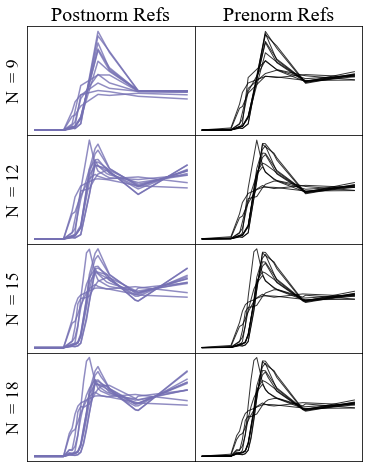

In [51]:
colors = [plt.cm.Dark2(2), plt.cm.Dark2(0)]
nrows = len(n_points_rfe)
ncols = 2
fig, axes = plt.subplots(figsize=(3 * ncols, 2 * nrows), nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0, wspace=0)

for j, n_pts in enumerate(n_points_rfe):
    for i, r in enumerate(Sub_Refs[j]):
        axes[j, 0].plot(energy[Indices[j]], r, '-', alpha=0.8,
                         c=colors[0], lw=1.5, zorder=1e6)
        axes[j, 1].plot(energy[Indices[j]], Refs[:, Indices[j]][i], '-', alpha=0.8,
                        c='k', lw=1., zorder=1e6)
        axes[j, 0].set_ylabel(f'N  = {n_pts + 3}', fontsize=18)

for axl in axes:
    for ax in axl:
        ax.set_xticks([])
        ax.set_yticks([])
axes[0, 0].set_title('Postnorm Refs', fontsize=20)
axes[0, 1].set_title('Prenorm Refs', fontsize=20)
plt.show()

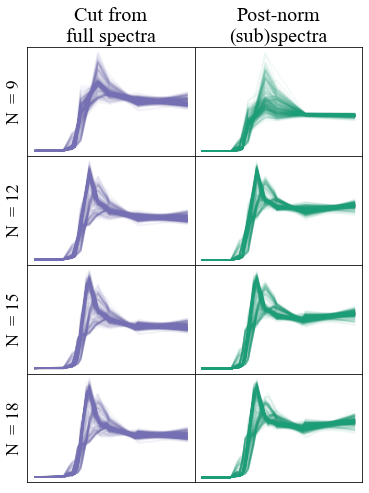

In [112]:
colors = [plt.cm.Dark2(2), plt.cm.Dark2(0)]
nrows = len(n_points_rfe)
ncols = 2
fig, axes = plt.subplots(figsize=(3 * ncols, 2 * nrows), nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0, wspace=0)

for j, n_pts in enumerate(n_points_rfe):
#     for i, r in enumerate(Sub_Refs[j]):
#         axes[j, 0].plot(energy[Indices[j]], r, '-', alpha=0.8,
#                          c=colors[0], lw=1.5, zorder=1e6)
#         axes[j, 0].plot(energy[Indices[j]], Refs[:, Indices[j]][i], '-', alpha=0.2,
#                         c='k', lw=1., zorder=1e6)
    for i, s in enumerate(Sub_Data[j]):
        if i % 20 == 0:
            axes[j, 0].plot(energy[Indices[j]], normalized_spectra[i, Indices[j]], '-', alpha=0.05,
                            c=colors[0], lw=1.5, zorder=1e6)
            axes[j, 1].plot(energy[Indices[j]], s, '-', alpha=0.05,
                            c=colors[1], lw=1.5, zorder=1e6)
    axes[j, 0].set_ylabel(f'N  = {n_pts + 3}', fontsize=18)

for axl in axes:
    for ax in axl:
        ax.set_xticks([])
        ax.set_yticks([])
axes[0, 0].set_title('Cut from\nfull spectra', fontsize=20)
axes[0, 1].set_title('Post-norm\n(sub)spectra', fontsize=20)
plt.show()

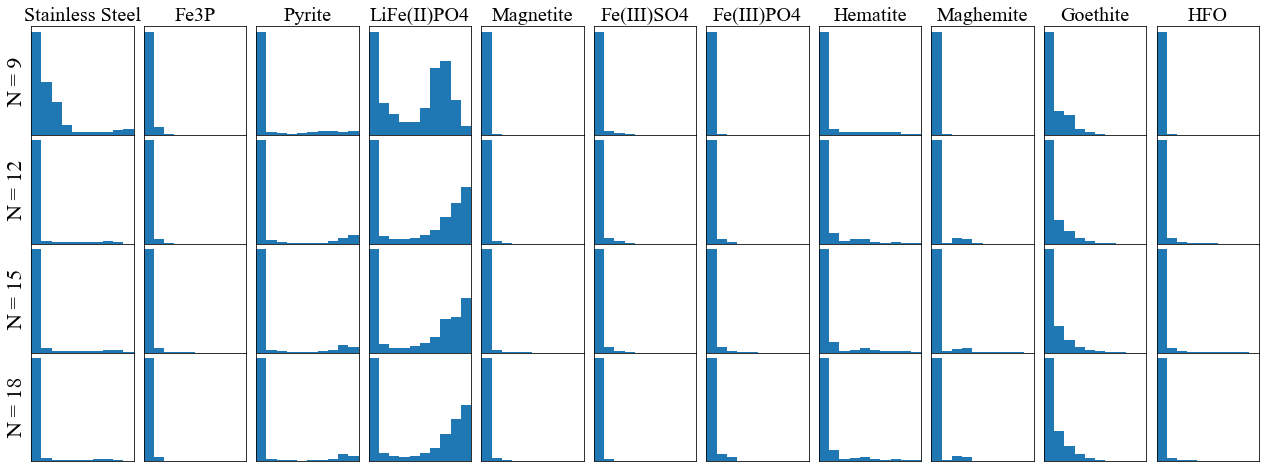

In [53]:
nrows = len(n_points_rfe)
ncols = 11
fig, axes = plt.subplots(figsize=(2 * ncols, 2 * nrows), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0.1, hspace=0)
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].hist(Pred_coeffs[i, :, j], bins=10, range=(0, 1))
        axes[i, j].set_xlim(0, 1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if j == 0:
            axes[i, j].set_ylabel(f'N = {n_points_rfe[i] + 3}', fontsize=22)
        if i == 0:
            axes[i, j].set_title(data_columns[j], fontsize=20)

In [8]:
def get_data_from_directory(directory, energy, comments=False):
    """Get all data (.e) files in listed directory."""
    
    datafiles = os.listdir(directory)
    filenames = [filename for filename in datafiles if filename.endswith('e')]
    if comments == False:
        Raw_data = {filename: np.loadtxt(f'{directory}{filename}').T for filename in filenames}
    else:
        Raw_data = {}
        for filename in filenames:
            data = []
            with open(f'{directory}{filename}') as f:
                for line in f:
                    if (not line.startswith('#')) and (not line.startswith('=')) and line != '\n':
                        parsed = line.replace('\t', ' ').replace('\n','').replace('E', 'e').split(' ')
                        try:
                            parsed = [float(e) for e in parsed] 
                            data.append(parsed)
                        except:
                            print(f"Can't parse '{line}' in file {filename}")                        
            f.close()
            data = np.array(data)
            Raw_data[filename] = data.T
    
    min_e = np.inf
    max_e = -np.inf
    for x, y in list(Raw_data.values()):
        minx = min(x)
        maxx = max(x)
        if minx < min_e:
            min_e = minx
        if maxx > max_e:
            max_e = maxx
    for x, y in list(Raw_data.values()):
        minx = min(x)
        maxx = max(x)
        if minx > min_e:
            min_e = minx
        if maxx < max_e:
            max_e = maxx
    #print(min_e, max_e)
    
    Data = {}
    for file, spectrum in Raw_data.items():
        x, y = spectrum
        interperlator = interp1d(x, y)
        interpolated_y = interperlator(energy)
        Data[file] = np.array([energy, interpolated_y])
    DATA = np.array(list(Data.values()))[:, 1, :]
    print(DATA.shape)
    
    return Data, DATA

In [52]:
ref_dict, large_ref_library = get_data_from_directory('Data/References/', energy, comments=True)

true_indices = np.array([0, 2, 3, 7])
extra_indices = np.array([i for i in np.arange(len(Refs)) if i not in true_indices])
large_indices = np.arange(len(large_ref_library))

Large_Refs = list(Refs[true_indices])
for idx in extra_indices:
    Large_Refs.append(Refs[idx])
for idx in add_idxs:
    Large_Refs.append(large_ref_library[idx])  
Large_Refs = np.array(Large_Refs)
print(Large_Refs.shape)

(65, 54)
(75, 54)


In [10]:
def get_n_pca_components(data, threshold=0.99):
    n = min(data.shape)
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            text = f"It takes {i + 1} PCs to explain\n{int(threshold*100)}% variance."
            n_components = i + 1
            break
    return n_components

In [12]:
library_sizes = np.arange(4, 11 + 65)
N_comps = [[] for s in library_sizes]
reps = 500

for l, library_size in enumerate(library_sizes):
    for rep in np.arange(reps):
        if library_size == 4:
            ref_set = Refs[true_indices]
        elif library_size <= 11:
            add_idxs = np.random.choice(extra_indices, size=library_size - 4, replace=False)
            ref_set = list(Refs[true_indices])
            for idx in add_idxs:
                ref_set.append(Refs[idx])
        elif library_size <= len(true_indices) + len(large_indices) + len(extra_indices):
            add_idxs = np.random.choice(large_indices, size=library_size - 11, replace=False)
            ref_set = list(Refs[true_indices])
            for idx in extra_indices:
                ref_set.append(Refs[idx])
            for idx in add_idxs:
                ref_set.append(large_ref_library[idx])            
        ref_set = np.array(ref_set)
        n_components = get_n_pca_components(ref_set, threshold=0.99)
        N_comps[l].append(n_components)
N_comps = np.array(N_comps)

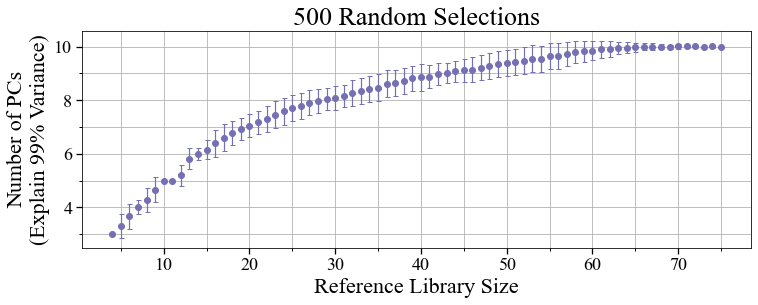

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.errorbar(library_sizes, np.average(N_comps, axis=1), capsize=2.5,
            yerr=np.std(N_comps, axis=1), c=plt.cm.Dark2(2), linewidth=1.2,
            capthick=1., marker='o', linestyle='none')
ax.tick_params(length=6, width=1.3, labelsize=18, which='major')
ax.tick_params(length=3, width=1, which='minor')
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlabel('Reference Library Size', fontsize=22)
ax.set_ylabel('Number of PCs\n(Explain 99% Variance)', fontsize=22)
ax.set_title(f'{reps} Random Selections', fontsize=26)
ax.grid(which='both')
plt.savefig('Figures/Scree_for_large_ref_library_size.png', dpi=600, bbox_inches='tight')

It takes 5 PCs to explain
99% variance.
It takes 10 PCs to explain
99% variance.


Text(0.5, 1.0, 'Reference N = 76')

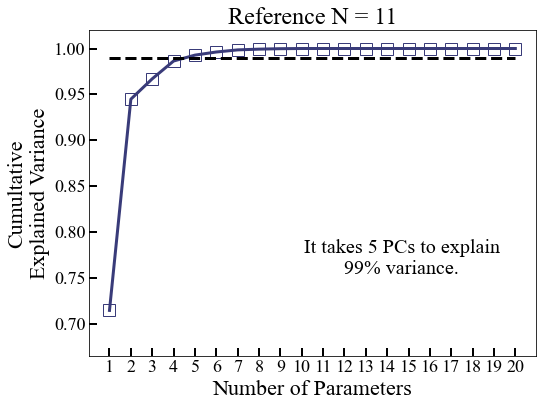

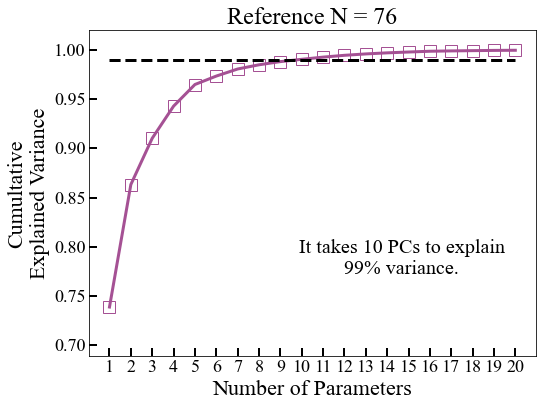

In [14]:
n_components = make_scree_plot(Refs, n=20, threshold=0.99, c=0)
plt.title(f'Reference N = {len(Refs)}', fontsize=24)

n_components = make_scree_plot(Large_Refs, n=20, threshold=0.99, c=17)
plt.title(f'Reference N = {len(Large_Refs)}', fontsize=24)

In [72]:
pca = PCA(n_components=10)
pca_components = pca.fit_transform(Large_Refs)
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=5, min_dist=0.)
reduced_space = reducer.fit_transform(pca_components)

Text(0.5, 1.0, 'Forced Clusters')

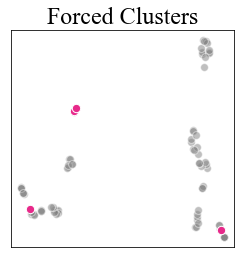

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(reduced_space[4:, 0], reduced_space[4:, 1], marker='o', s=60, color='gray', 
           alpha=0.5, ec='w', lw=1)
ax.scatter(reduced_space[4:11, 0], reduced_space[4:11, 1], marker='o', s=60, color='gray', 
           alpha=0.5, ec='w', lw=1)
ax.scatter(reduced_space[:4, 0], reduced_space[:4, 1], marker='o', s=70, color=plt.cm.Dark2(3), 
           alpha=1, ec='w', lw=1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Forced Clusters', fontsize=24)